In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS

from sklearn.tree import (DecisionTreeClassifier as DTC, 
                          DecisionTreeRegressor as DTR, 
                          plot_tree, 
                          export_text)
from sklearn.ensemble import (RandomForestClassifier as RFC,GradientBoostingRegressor as GBC)
from sklearn.metrics import (accuracy_score, 
                             log_loss)
from ISLP.bart import BART

In [63]:
data = load_data("Carseats")
high = np.where(data.Sales > 8, "Yes", "No")
design = MS(data.columns.drop("Sales"), intercept=False)
x = design.fit_transform(data)
feature_names = x.columns
x_dat = np.asarray(x)


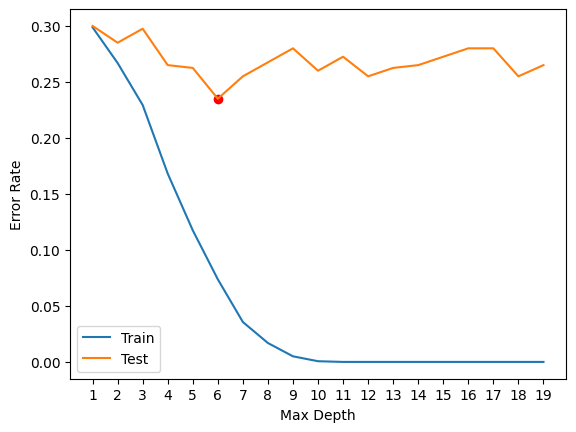

In [64]:
max_depth = np.arange(1,20)
cv = skm.ShuffleSplit(5, test_size=0.2, random_state=0)
train_err = np.zeros_like(max_depth, dtype=float)
test_err = np.zeros_like(max_depth, dtype=float)

for train_idx, test_idx in cv.split(x_dat) : 
    x_train, x_test = x_dat[train_idx], x_dat[test_idx]
    y_train, y_test = high[train_idx], high[test_idx]
    for i, d in enumerate(max_depth) : 
        dtc = DTC(max_depth=d)
        dtc.fit(x_train, y_train)
        train_err[i] += 1 - accuracy_score(y_train, dtc.predict(x_train))
        test_err[i] += 1 - accuracy_score(y_test, dtc.predict(x_test))
train_err /= cv.get_n_splits()
test_err /= cv.get_n_splits()

fig, ax = plt.subplots()
ax.plot(max_depth, train_err, label="Train")
ax.plot(max_depth, test_err, label="Test")
ax.scatter(np.argmin(test_err)+1, np.min(test_err), color="red")
ax.set_xlabel("Max Depth")
ax.set_ylabel("Error Rate")
ax.set_xticks(max_depth)
ax.legend()
plt.show()

# max_depth = 6 - performs well

In [ ]:
clf = DTC(max_depth=6, criterion="entropy", random_state=0)
clf.fit(x_dat, high)


0.91

In [77]:
resid_dev = np.sum(log_loss(high, clf.predict_proba(x_dat)))
print(f"Residual deviance: {resid_dev:.3f}")
print(f"Accuracy Score : {accuracy_score(high, clf.predict(x_dat)):.3f}")

Residual deviance: 0.181
Accuracy Score : 0.910


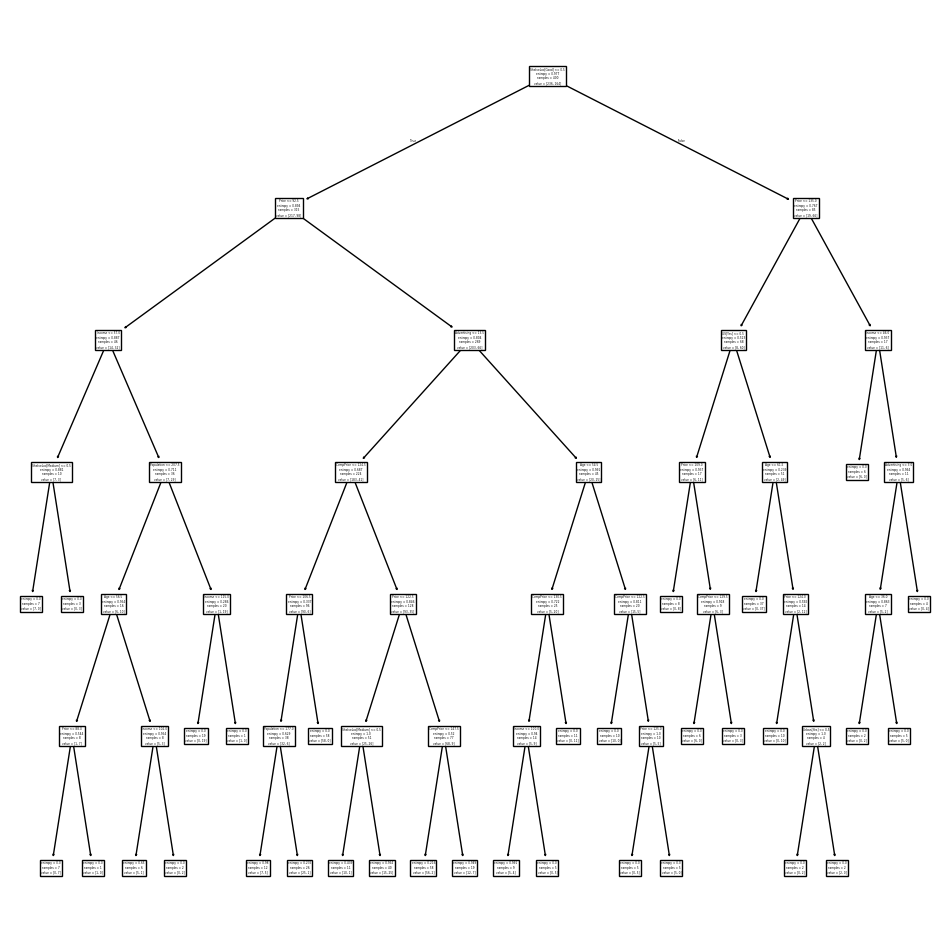

In [83]:
fig, ax = plt.subplots(figsize=(12,12))
plot_tree(clf, feature_names=feature_names, ax = ax)
plt.show()

In [86]:
print(export_text(clf, feature_names=feature_names, show_weights=True))

|--- ShelveLoc[Good] <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- ShelveLoc[Medium] <= 0.50
|   |   |   |   |--- weights: [7.00, 0.00] class: No
|   |   |   |--- ShelveLoc[Medium] >  0.50
|   |   |   |   |--- weights: [0.00, 3.00] class: Yes
|   |   |--- Income >  57.00
|   |   |   |--- Population <= 207.50
|   |   |   |   |--- Age <= 56.50
|   |   |   |   |   |--- Price <= 88.00
|   |   |   |   |   |   |--- weights: [0.00, 7.00] class: Yes
|   |   |   |   |   |--- Price >  88.00
|   |   |   |   |   |   |--- weights: [1.00, 0.00] class: No
|   |   |   |   |--- Age >  56.50
|   |   |   |   |   |--- Income <= 102.00
|   |   |   |   |   |   |--- weights: [5.00, 1.00] class: No
|   |   |   |   |   |--- Income >  102.00
|   |   |   |   |   |   |--- weights: [0.00, 2.00] class: Yes
|   |   |   |--- Population >  207.50
|   |   |   |   |--- Income <= 115.00
|   |   |   |   |   |--- weights: [0.00, 19.00] class: Yes
|   |   |   |   |--- Income >  115.00
|   |  

In [89]:
cv = skm.ShuffleSplit(5, test_size=0.2, random_state=0)
results = skm.cross_validate(clf, x_dat, high, cv=cv, return_train_score=True)
print(f"Train Score: {results['train_score'].mean():.3f}")
print(f"Test Score: {results['test_score'].mean():.3f}")

Train Score: 0.920
Test Score: 0.753


In [117]:
# Pruning might lead to improved performance
clf = DTC(max_depth=6, criterion="entropy", random_state=0)

cv = skm.ShuffleSplit(1, test_size=0.4, random_state=0)
for train_idx, test_idx in cv.split(x_dat) : 
    x_train, x_test = x_dat[train_idx], x_dat[test_idx]
    y_train, y_test = high[train_idx], high[test_idx]
    clf.fit(x_train, y_train)
    print(f"Train Score: {accuracy_score(y_train, clf.predict(x_train)):.3f}")
    print(f"Test Score: {accuracy_score(y_test, clf.predict(x_test)):.3f}")
    

Train Score: 0.925
Test Score: 0.738


In [116]:
confusion_table(y_test, clf.predict(x_test))

Truth,No,Yes
Predicted,,
No,72,18
Yes,24,46


Analysis of confusion table : 
- Accuracy = $\frac{72 + 46}{160} \approx 0.7375 (73.75\%)$
- Precision = $\frac{46}{46+24} \approx 0.6571 (65.71\%)$
- Recall = $\frac{46}{46+18} \approx 0.71875 (71.875\%)$
- Specificity = $\frac{72}{72 + 24} \approx 0.75 (75\%)$

Precision : Of all Predicted positives, how many were true positives. -> False Positives Rate
Recall : Of all Actual positives, how many were true positives. -> False Negative Rate
Specificity : Of all Actual negatives, how many were true negatives -> False Positives

In [122]:
ccp_path = clf.cost_complexity_pruning_path(x_train, y_train) # Yield
kfold = skm.ShuffleSplit(5, test_size=0.2, random_state=0)
alpha = ccp_path["ccp_alphas"]
grid = skm.GridSearchCV(clf, {"ccp_alpha": alpha}, cv=kfold, refit=True, scoring="accuracy")
grid.fit(x_train, y_train)
grid.best_score_

0.7208333333333333

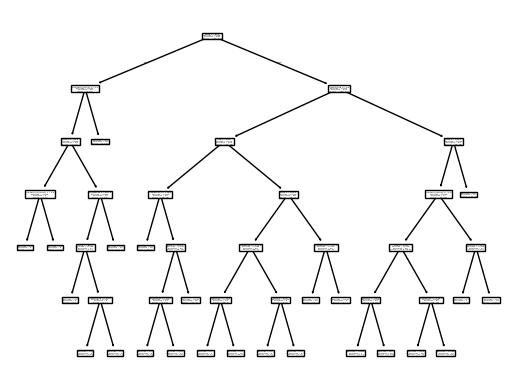

In [124]:
fig, ax = plt.subplots()
best_ = grid.best_estimator_
plot_tree(best_, feature_names=feature_names, ax=ax)
plt.show()

# Still a very bushy tree

In [127]:
best_.tree_.n_leaves
# The tree with 24 leaves, results a crossValidated accuracy of 0.72

24

In [129]:
confusion_table(y_test, best_.predict(x_test))

Truth,No,Yes
Predicted,,
No,72,18
Yes,25,45


Analysis :
1. Accuracy : $\frac{72 + 45}{160} \approx 0.731 (73.1\%)$
2. Precision : $\frac{45}{45 + 25} \approx 0.64285 (64.28\%)$
3. Recall : $\frac{45}{45 + 18} \approx 0.71428 (71.42\%)$
4. Specificity : $\frac{72}{72+25} \approx 0.7422 (74.22\%)$

Inferences : 
- Around 64.28% of predicted positives were actual positives
- Around 71.42% of actual positives were true positives
- Around 74.22% of actual negatives were true negatives

There could be a lot of false positives & negatives as evident by the numbers

#### Functions Used : 
- `np.where(condition, ifTrue, ifFalse)` -> For classifying
- `DecisionTreeClassifier()` : For a decision tree classifying
- `cost_complexity_path()` : To extract cost-complexity values and impurities values to be used for prunning

##### Notes : 
- We have converted from `DataFrame` to `np.ndarray()` because `DTC` support only numpy array
- HyperParameters : 
  - `max_depth` : how deep to grow the tree
  - `min_samples_split` : minimum number of observations in a node to be eligible for splitting
  - `criterion` : which criteria to use for splitting i.e. Gini or cross - entropy
- `accuracy_score(y, predicted)` : accuracy score for the predictions 